In [1]:
import inspect
import re
import math
from pathlib import Path
import shutil
import time
from typing import List, Literal, Union, Optional

import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from sparrow import Protein
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    explained_variance_score,
    r2_score
)
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
import mlflow
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from libs.data_loading_generated import calculate_features_simulation
from libs.functions import CustomEstimator, load_cfg
from better_da import process_density_file
from ppd import find_crit_temp


pd.set_option('display.max_columns', 100)

In [2]:
experiment_folder = Path().resolve().joinpath('experiments')
experiment_name = 'bayesian_cv_search_new'

if not experiment_folder.is_dir():
    experiment_folder.mkdir()
else:
    shutil.rmtree(experiment_folder)
    experiment_folder.mkdir()
    

mlflow.set_tracking_uri(f'file://{experiment_folder}')
mlflow.set_experiment(experiment_name)

2025/02/24 20:44:02 INFO mlflow.tracking.fluent: Experiment with name 'bayesian_cv_search_new' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/vik/toptal/harryschemlab/HarryML/experiments/447076450223531366', creation_time=1740426242357, experiment_id='447076450223531366', last_update_time=1740426242357, lifecycle_stage='active', name='bayesian_cv_search_new', tags={}>

In [3]:

def filter_duplicated_files(paths_files: List[Path]) -> List[Path]:

    filtered_paths = []
    
    for pf in paths_files:
        match = re.search(r"\(\d+\)", pf.name)

        if not match:
            filtered_paths.append(pf)
    
    return filtered_paths


def compute_critical_temperatures(df: pd.DataFrame) -> pd.DataFrame:
    
    critical_temperatures = []

    for _, df_part in df.groupby('protein_name'):
        
        crit_temp, _ = find_crit_temp(df_part['dense_conc'], df_part['conc_dilute'], df_part['temp'])
        critical_temperatures.extend([crit_temp for i in range(len(df_part))])
        
    df['ct'] = np.array(critical_temperatures, dtype=np.float32)
    
    return df


def compute_protein_features(
    df_proteins: pd.DataFrame, 
    df_sequences: pd.DataFrame
) -> pd.DataFrame:
    """"""
    estimators = {
        "CUSTOM": CustomEstimator,
        "BIOPYTHON": ProteinAnalysis,
        "SPARROW": Protein,
        "SPARROW_PREDICTOR": Protein
    }
    cfg = load_cfg("configs/features_config.json")

    proteins_features = []
    proteins = df_proteins.protein_name.tolist()

    for prot in tqdm(proteins):

        prot_seq = df_sequences.loc[df_sequences['UniProt_ID'] == prot].fasta.tolist()[0]
        prot_seq_features = {
            'sequence': prot_seq
        }
        for estimator_name, estimator_methods in cfg['ESTIMATORS'].items():
            if estimator_name != "SPARROW_PREDICTOR":
                estimator = estimators[estimator_name](prot_seq)
            else:
                estimator = estimators[estimator_name](prot_seq).predictor
                
            for feature_name, params  in estimator_methods.items():
                method_name, args, kwargs = params
                method = getattr(estimator, method_name)
                
                if inspect.ismethod(method):
                    value = method(*args, **kwargs)
                else:
                    if args:
                        raise ValueError(f"non-empty arguments for class property - {method_name}")
                    else:
                        value = method
                        
                prot_seq_features[feature_name] = value
            
        proteins_features.append(prot_seq_features)
            
    df_prot_feats = pd.DataFrame(proteins_features)
    df_prot_feats = pd.concat([df_proteins, df_prot_feats], axis=1)

    return df_prot_feats


def preprocess(
    path_config: Path,
    path_data: Path,
    calc_type: str = 'v3',
    dense_raw: bool = False,
    corr_threshold: Optional[float] = 0.9,
    remove_correlated: bool = True
) -> pd.DataFrame:
    """"""
    df = calculate_features_simulation(path_config, path_data, 
                                       calc_type=calc_type, dens_raw=dense_raw)
    
    columns_to_drop = ['charge_segregation_kappa(S)']
    
    for column_name in df.columns:
        if (
            not pd.api.types.is_numeric_dtype(df[column_name])
            and column_name != 'seq'
            and not column_name.endswith('_T')
        ):
            columns_to_drop.append(column_name)

    df = df.drop(labels=columns_to_drop, axis=1)

    temp_cols = [col for col in df.columns if col.endswith('_T')]
    ct_cols = [col for col in df.columns if col == 'ct']
    cols_to_exclude = temp_cols + ct_cols + ['seq']
    x_columns = [col for col in df.columns if col not in cols_to_exclude]
        
    parts = []

    for col in temp_cols:
        cols_to_select = x_columns + ct_cols + [col]
        df_tmp = df.loc[df[col].notnull(), cols_to_select]
        df_tmp.reset_index(names=['gene'], inplace=True)
        df_tmp['temp'] = float(col.split('_')[0])
        df_expanded = pd.json_normalize(df_tmp[col].apply(lambda x: x['conc']))
        df_tmp.drop(labels=[col], axis=1, inplace=True)
        df_tmp = pd.concat([df_tmp, df_expanded], axis=1)
        parts.append(df_tmp)
        
    df_res = pd.concat(parts)
    
    if remove_correlated:        
        corr_matrix = df_res[x_columns].corr().abs()
        
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        cols_to_drop = [col for col in upper.columns if any(upper[col] > corr_threshold)]
        
        df_res.drop(columns=cols_to_drop, inplace=True)
    
    return df_res


def run_ml_pipeline(
    df_proteins: pd.DataFrame,
    target: str,
    targets_to_remove: List[str],
    model: Union[SVR, RandomForestRegressor],
    search_space: dict,
    n_iter: int,
    cv_folds: int,
    num_cores: int,
    seed: int,
    dataset: Literal['old', 'new', 'combined'],
    plot_predictions: bool = True,
) -> Union[SVR, RandomForestRegressor]:
    """"""
    col_pred = 'pred'
    col_temp = 'temp'
    col_protein = 'protein_name'
    
    main_metric = 'r2'
    scoring_metrics = [
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error',
        'r2',
        'explained_variance'
    ]
    metrics = [
        mean_absolute_error,
        mean_squared_error,
        root_mean_squared_error,
        r2_score,
        explained_variance_score
    ]
    scaler_features = StandardScaler()
    
    print("Preprocessing input data...")
    
    features = [col for col in df_proteins.columns if col != target and col != col_protein and col not in targets_to_remove]

    proteins = df_proteins[col_protein].unique()

    train_proteins, test_proteins = train_test_split(proteins, train_size=0.8, random_state=seed, shuffle=True)

    print(f"Training on {len(train_proteins)} proteins")
    print(f"Testing on {len(test_proteins)} proteins")

    df_src = df_proteins.copy()
    df_src.drop(targets_to_remove, axis=1, inplace=True)

    df_train = df_src.loc[df_proteins[col_protein].isin(train_proteins)]
    df_test = df_src.loc[df_proteins[col_protein].isin(test_proteins)]

    x_train, y_train = df_train.loc[:, features], df_train.loc[:, [target]].values.ravel()
    x_test, y_test = df_test.loc[:, features], df_test.loc[:, [target]].values.ravel()

    x_train = scaler_features.fit_transform(x_train)
    x_test = scaler_features.transform(x_test)
    
    print(f"Searching for the best {type(model).__name__} hyperparameters with Bayesian Search...")
    
    bayes_search = BayesSearchCV(
        model,
        search_space,
        scoring=scoring_metrics,
        refit=main_metric,
        n_iter=n_iter,
        cv=cv_folds,
        n_jobs=num_cores,
        verbose=1,
        random_state=seed
    )
    start_time = time.time()

    bayes_search.fit(x_train, y_train)

    end_time = time.time()
    elapsed_time = (end_time - start_time) / 60

    print(f"Bayesian optimization completed in {elapsed_time:.2f} minutes.")
    print("Best parameters found:", bayes_search.best_params_)
    print("Test score:", bayes_search.score(x_test, y_test))
    
    log_experiment_results(bayes_search, model, scoring_metrics, target, dataset)
    
    model = bayes_search.best_estimator_
    model.fit(x_train, y_train)
    
    test_preds = model.predict(x_test)

    for metr in metrics:
        print(f'{metr.__name__}: {metr(y_test, test_preds):.4f}')
    
    print("Plotting Test predictions...")
    
    df_plot = df_proteins.loc[df_proteins[col_protein].isin(test_proteins), [col_protein, col_temp, target]]
    df_plot.loc[:, col_pred] = test_preds
    
    model_name = type(model).__name__
    
    if plot_predictions:
        if target == 'ct':
            plot_critical_temperature_preds(
                model_name, df_plot, test_proteins, col_protein, target, col_pred
            )
        else:
            plot_contentration_preds(
                model_name, df_plot, test_proteins, col_temp, target, col_pred,
                horizontal_spacing=0.05, vertical_spacing=0.05, row_height=300,
                plot_width=1200
            )
        
    train_preds = model.predict(x_train)
    df_train[col_pred] = train_preds
    df_test[col_pred] = test_preds
    
    df_train['train'], df_test['train'] = True, False
    df_all = pd.concat([df_train, df_test], axis=0)
        
    return model, df_all
        
        
def log_experiment_results(
    bayes_search: BayesSearchCV,
    model: Union[SVR, RandomForestRegressor],
    scoring_metrics: List[str],
    target: str,
    dataset: Literal['old', 'new', 'combined']
) -> None:

    for idx, params in enumerate(bayes_search.cv_results_['params']):
        
        with mlflow.start_run():
            
            for param_name, param_value in params.items():
                mlflow.log_param(param_name, param_value)
                
            mlflow.log_param('model', type(model).__name__)
            mlflow.log_param('target', target)
            mlflow.log_param('dataset', dataset)
            
            for metr in scoring_metrics:
                key_mean = f'mean_test_{metr}'
                key_std = f'std_test_{metr}'
                score_mean = abs(round(bayes_search.cv_results_[key_mean][idx], 4))
                score_std = round(bayes_search.cv_results_[key_std][idx], 4)
                metr = metr.replace('neg_', '')
                
                mlflow.log_metric(f'{metr}_mean', score_mean)
                mlflow.log_metric(f'{metr}_std', score_std)
                
        
def plot_critical_temperature_preds(
    model_name: str,
    df: pd.DataFrame, 
    proteins: List[str], 
    column_protein: str,
    column_target: str,
    column_prediction: str,
    plot_width: int = 800,
    plot_height: int = 600
) -> None:
    """"""
    fig = go.Figure()

    for protein_name in proteins:
        df_tmp = df.loc[df.protein_name == protein_name]

        fig_protein_true = px.scatter(
            df_tmp, 
            x=column_protein, 
            y=column_target,
            labels={column_protein: "Protein", column_target: column_target},
            color_discrete_sequence=['blue'],
            symbol_sequence=['circle']
        )
        fig_protein_pred = px.scatter(
            df_tmp, 
            x=column_protein,
            y=column_prediction,
            labels={column_protein: "Protein", column_prediction: column_target},
            color_discrete_sequence=['orange'],
            symbol_sequence=['x']
        )
        for trace in fig_protein_true.data:
            fig.add_trace(trace)
        for trace in fig_protein_pred.data:
            fig.add_trace(trace)

    fig.update_layout(
        height=plot_height,
        width=plot_width,
        title_text=f"{model_name} Regression for {column_target}",
        title_x=0.5,
        showlegend=True,
        template="plotly_white",
        xaxis_title="Protein",
        yaxis_title=column_target,
        xaxis=dict(tickangle=45)
    )

    fig.show()
                
                
def plot_contentration_preds(
    model_name: str,
    df: pd.DataFrame, 
    proteins: List[str], 
    column_temperature: str,
    column_target: str,
    column_prediction: str,
    horizontal_spacing: float = 0.1,
    vertical_spacing: float = 0.1,
    row_height: int = 300,
    plot_width: int = 1200
) -> None:
    
    n_cols = 3    
    n_rows = math.ceil(len(proteins) / n_cols)

    fig = make_subplots(
        rows=n_rows, cols=n_cols, 
        subplot_titles=[f"Protein {prot}" for prot in proteins],
        shared_xaxes=False, 
        shared_yaxes=False,
        horizontal_spacing=horizontal_spacing,
        vertical_spacing=vertical_spacing
    )

    for idx, protein_name in enumerate(proteins):
        
        df_tmp = df.loc[df.protein_name == protein_name]
        
        fig_protein_true = px.scatter(
            df_tmp, 
            x=column_temperature, 
            y=column_target,
            labels={column_temperature: "Temperature", column_target: column_target},
            title=f'Protein {protein_name}',
            color_discrete_sequence=['blue'],
            symbol_sequence=['circle']
        )
        fig_protein_pred = px.scatter(
            df_tmp, 
            x=column_temperature,
            y=column_prediction,
            labels={column_temperature: "Temperature", column_prediction: column_target},
            title=f'Protein {protein_name}',
            color_discrete_sequence=['orange'],
            symbol_sequence=['x']
        )
        fig.add_trace(fig_protein_true.data[0], row=(idx // n_cols) + 1, col=(idx % n_cols) + 1)
        fig.add_trace(fig_protein_pred.data[0], row=(idx // n_cols) + 1, col=(idx % n_cols) + 1)

    fig.update_layout(
        height=row_height * n_rows,
        width=plot_width,
        title_text=f"{model_name} Regression for {column_target}",
        title_x=0.5,
        showlegend=True,
        template="plotly_white"
    )

    fig.show()

### Set process_new_files = True 1st time

In [4]:
process_new_files = False

path_data = Path().resolve().joinpath('data', 'new_data')
paths_files = list(path_data.iterdir())
paths_files = filter_duplicated_files(paths_files)

print(f"{len(paths_files)} new files")

364 new files


In [5]:
for pf in paths_files:
    
    protein_name, dense, dilute, dense_stdev, dilute_stdev, temperature = process_density_file(pf)
    
    print(f"Protein: {protein_name}")
    print(f"Temperature: {temperature}")
    print(f"Dense phase concentration: {dense:.4f} ± {dense_stdev:.4f}")
    print(f"Dilute phase concentration: {dilute:.4f} ± {dilute_stdev:.4f}")
    
    break

Protein: Q8IYK2
Temperature: 270
Dense phase concentration: 0.0000 ± 0.0000
Dilute phase concentration: 0.0000 ± 0.0000


In [6]:
if process_new_files:
    path_data_processed = Path().resolve().joinpath('data', 'new_data_processed')

    if not path_data_processed.is_dir():
        path_data_processed.mkdir()

    path_data_processed = path_data_processed.joinpath('proteins_concs.parquet')

    columns = ['protein_name', 'dense_conc', 'conc_dilute', 'var_dense', 'var_dilute', 'temp']
    
    result = process_map(process_density_file, paths_files, max_workers=12)

    df = pd.DataFrame(result, columns=columns)
    df.to_parquet(path_data_processed, index=False)
    df.head()

### Read new data, Drop proteins with cT <= 150

In [7]:
path_data_processed = Path().resolve().joinpath('data', 'new_data_processed', 'proteins_concs.parquet')

df = pd.read_parquet(path_data_processed)

df.sort_values('protein_name', inplace=True)

df = compute_critical_temperatures(df)

original_length = len(df)

df = df.loc[df.ct > 150].sort_values('protein_name').reset_index(drop=True)

print(f'Dropped {original_length - len(df)} proteins')
print(f"{df.protein_name.nunique()} proteins from .dat files")

Dropped 32 proteins
83 proteins from .dat files


/tmp/ipykernel_65780/3920784150.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  df['ct'] = np.array(critical_temperatures, dtype=np.float32)


In [8]:
df.isnull().sum()

protein_name    0
dense_conc      0
conc_dilute     0
var_dense       0
var_dilute      0
temp            0
ct              0
dtype: int64

In [9]:
path_sequences = Path().resolve().joinpath('data', 'sequences')

df_seqs = pd.concat([pd.read_csv(path_sequences.joinpath(f'subset_{i}.csv')) for i in range(1,3)])

sequences_proteins = set(df_seqs['UniProt_ID'].tolist())
protein_names = set(df.protein_name.unique())

print(f"{len(protein_names - sequences_proteins)} missing proteins / sequences")

df_prot_feats = compute_protein_features(df, df_seqs)

df_prot_feats

0 missing proteins / sequences


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/sparrow/predictors/scaled_rg/scaled_radius_of_gyration_predictor.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Error importing GPy.
 If trying to run parrot-optimize, make sure to use `pip install idptools-parrot[optimize]`


100%|███████████████████████████████████████████████████████████████████| 332/332 [00:08<00:00, 40.30it/s]


protein_name  dense_conc  conc_dilute  var_dense  var_dilute  temp  \
0     A0A1B0GVM6    0.351657     0.058309   0.022154    0.012740   234   
1     A0A1B0GVM6    0.306350     0.097605   0.003079    0.000812   239   
2     A0A1B0GVM6    0.398776     0.016467   0.025538    0.019664   229   
3     A0A1B0GVM6    0.428317     0.012680   0.034236    0.018642   224   
4         A4D0V7    0.312916     0.039775   0.004688    0.025791   256   
..           ...         ...          ...        ...         ...   ...   
327       Q8NCE0    0.321716     0.043779   0.017119    0.025331   201   
328       Q8NEU8    0.306901     0.055863   0.004391    0.030579   171   
329       Q8NEU8    0.000000     0.059362   0.000000    0.022111   176   
330       Q8NEU8    0.000000     0.078749   0.000000    0.009673   181   
331       Q8NEU8    0.373679     0.019403   0.025152    0.026549   166   

             ct                                           sequence  \
0    240.634918  MTGEEAVVVTAVVAPKAGREEEQPPPPAGLGCGARGEPGRGPLEHG...   
1    240.634918  MTGEEAVVVTAVVAPKAGREEEQPPPPAGLGCGARGEPGRGPLEHG...   
2    240.634918  MTGEEAVVVTAVVAPKAGREEEQPPPPAGLGCGARGEPGRGPLEHG...   
3    240.634918  MTGEEAVVVTAVVAPKAGREEEQPPPPAGLGCGARGEPGRGPLEHG...   
4    263.385803  MVCRPVFPCRRRFCPRPFLVGLVVAICLFYQTLTLRGSRKLTAAAP...   
..          ...                                                ...   
327  205.386398  TKPLEHPPVKRNEEAQVHDKLNSGMVSNMEGTAGGERPSVVNGDSG...   
328  178.431992  LTDNPEAVAIKLNQTALQAVTPITSFGKKQESSCPSQNLKNSEMEN...   
329  178.431992  LTDNPEAVAIKLNQTALQAVTPITSFGKKQESSCPSQNLKNSEMEN...   
330  178.431992  LTDNPEAVAIKLNQTALQAVTPITSFGKKQESSCPSQNLKNSEMEN...   
331  178.431992  LTDNPEAVAIKLNQTALQAVTPITSFGKKQESSCPSQNLKNSEMEN...   

     arginine_count  molecular_weight  isoelectric_pint  aromaticity  \
0          0.087302        13913.8561          9.434900     0.047619   
1          0.087302        13913.8561          9.434900     0.047619   
2          0.087302        13913.8561          9.434900     0.047619   
3          0.087302        13913.8561          9.434900     0.047619   
4          0.079268        18260.9855          9.560742     0.079268   
..              ...               ...               ...          ...   
327        0.059603        16317.8135          5.108882     0.013245   
328        0.025641        12864.1289          4.256297     0.051282   
329        0.025641        12864.1289          4.256297     0.051282   
330        0.025641        12864.1289          4.256297     0.051282   
331        0.025641        12864.1289          4.256297     0.051282   

     net_charge  hydropathy_index  length  \
0      5.933893         -0.718254     126   
1      5.933893         -0.718254     126   
2      5.933893         -0.718254     126   
3      5.933893         -0.718254     126   
4      9.969632         -0.224390     164   
..          ...               ...     ...   
327  -11.821360         -0.856954     151   
328  -11.209752         -0.569231     117   
329  -11.209752         -0.569231     117   
330  -11.209752         -0.569231     117   
331  -11.209752         -0.569231     117   

                                           composition  \
0    {'A': 0.07936507936507936, 'C': 0.023809523809...   
1    {'A': 0.07936507936507936, 'C': 0.023809523809...   
2    {'A': 0.07936507936507936, 'C': 0.023809523809...   
3    {'A': 0.07936507936507936, 'C': 0.023809523809...   
4    {'A': 0.06707317073170732, 'C': 0.042682926829...   
..                                                 ...   
327  {'A': 0.052980132450331126, 'C': 0.03973509933...   
328  {'A': 0.08547008547008547, 'C': 0.008547008547...   
329  {'A': 0.08547008547008547, 'C': 0.008547008547...   
330  {'A': 0.08547008547008547, 'C': 0.008547008547...   
331  {'A': 0.08547008547008547, 'C': 0.008547008547...   

                                           flexibility  instability_index  \
0    [0.9929285714285715, 0.9902500000000002, 0.984...          76.036508   
1    [0.992928571

### Read old proteins

In [10]:
df_old_proteins = preprocess(
    "configs/features_config.json", "data/FINISHED_SIMULATIONS/",
    calc_type='v3', dense_raw=False, corr_threshold=None,
    remove_correlated=False
)

df_old_proteins.columns = [col.replace('(C)', '').replace('(BP)', '').replace('(SP)', '').replace('(S)', '') for col in df_old_proteins.columns]
df_old_proteins.rename(columns={'gene': 'protein_name'}, inplace=True)

Skipping line due to IndexError:   8 0.15
Skipping line due to IndexError:   25 0.49
Skipping line due to IndexError:   22


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/sparrow/predictors/scaled_rg/scaled_radius_of_gyration_predictor.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

In [11]:
df_old_proteins

protein_name  arginine_count  molecular_weight  isoelectric_pint  \
0     I0FUN3_MACMU_-5N+5Q        0.010753        10490.3476          5.966582   
1           ROAA_-10Q+10N        0.055046        11784.0666          9.361986   
2   I0FUN3_MACMU_-15Q+15N        0.010753        10209.8156          5.966582   
3           ROAA_-15G+15T        0.055046        12585.1216          9.361986   
4           ROAA_-10G+10T        0.055046        12364.8586          9.361986   
..                    ...             ...               ...               ...   
2     CCMM_SYNE7_-10s+10t        0.098765         8920.9116         10.253004   
0            TIA_-5w+5f_j        0.010309        10693.6042          5.751049   
0            TIA_-5w+5f_j        0.010309        10693.6042          5.751049   
0            TIA_-5w+5f_j        0.010309        10693.6042          5.751049   
0          tdp43_-10n+10q        0.016393        12054.9271          8.588817   

    aromaticity  net_charge  hydropathy_index  length  instability_index  \
0      0.161290   -0.272202         -1.081720      93          59.536559   
1      0.192661    5.822200         -1.624771     109          18.088073   
2      0.161290   -0.272202         -1.081720      93          15.797849   
3      0.192661    5.822200         -1.666055     109          22.098165   
4      0.192661    5.822200         -1.652294     109          21.672477   
..          ...         ...               ...     ...                ...   
2      0.061728    4.130572         -0.602469      81          25.098765   
0      0.154639   -0.505836         -0.860825      97          43.961959   
0      0.154639   -0.505836         -0.860825      97          43.961959   
0      0.154639   -0.505836         -0.860825      97          43.961959   
0      0.073770    0.762015         -0.569672     122          49.079508   

    fraction_of_charged_residues  fraction_of_positive_residues  \
0                       0.021505                       0.010753   
1                       0.128440                       0.091743   
2                       0.021505                       0.010753   
3                       0.128440                       0.091743   
4                       0.128440                       0.091743   
..                           ...                            ...   
2                       0.172840                       0.111111   
0                       0.020619                       0.010309   
0                       0.020619                       0.010309   
0                       0.020619                       0.010309   
0                       0.040984                       0.024590   

    fraction_of_negative_residues  net_charge_per_residue  \
0                        0.010753                0.000000   
1                        0.036697                0.055046   
2                        0.010753                0.000000   
3                        0.036697                0.055046   
4                        0.036697                0.055046   
..                            ...                     ...   
2                        0.061728                0.049383   
0                        0.010309                0.000000   
0                        0.010309                0.000000   
0                        0.010309                0.000000   
0                        0.016393                0.008197   

    sequence_charge_decoration_1  sequence_charge_decoration_2  \
0                      -0.024044                      4.440988   
1                       0.644674                      4.062512   
2                      -0.024044                      4.328889   
3                       0.644674                      4.137841   
4                       0.644674                      4.129539   
..                           ...                           ...   
2                       0.154468                      3.942084   
0                      -0.023052                      4.49028

In [14]:
col_mapper = {
    'gene': 'protein_name',
    #'dilute_conc': 'conc_dilute'
}

df_old_proteins = preprocess("configs/features_config.json", "data/FINISHED_SIMULATIONS/",
        calc_type='v3', dense_raw=False, corr_threshold=None,
        remove_correlated=False)

df_old_proteins.columns = [col.replace('(C)', '').replace('(BP)', '').replace('(SP)', '').replace('(S)', '') for col in df_old_proteins.columns]
df_old_proteins.rename(columns=col_mapper, inplace=True)

df_new_proteins = df_prot_feats.loc[:, [col for col in df_prot_feats.columns if col in df_old_proteins.columns]]

print(f"Old - New difference: {len(set(df_old_proteins.columns) - set(df_new_proteins.columns))}")
print(f"New - Old difference: {len(set(df_new_proteins.columns) - set(df_old_proteins.columns))}")

Skipping line due to IndexError:   8 0.15
Skipping line due to IndexError:   25 0.49
Skipping line due to IndexError:   22


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/sparrow/predictors/scaled_rg/scaled_radius_of_gyration_predictor.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

Old - New difference: 0
New - Old difference: 0


### Save old and new preprocessed data

In [15]:
path_data_preprocessed = Path().resolve().joinpath('data', 'new_data_preprocessed')

if not path_data_preprocessed.is_dir():
    path_data_preprocessed.mkdir()

path_old_proteins = path_data_preprocessed.joinpath('old_proteins.parquet')
path_new_proteins = path_data_preprocessed.joinpath('new_proteins.parquet')

In [16]:
df_old_proteins.to_parquet(path_old_proteins, index=False)
df_new_proteins.to_parquet(path_new_proteins, index=False)

### Read old and new preprocessed data

In [17]:
df_old_proteins = pd.read_parquet(path_old_proteins)
df_new_proteins = pd.read_parquet(path_new_proteins)

In [18]:
old_group = df_old_proteins.groupby('protein_name')['temp'].count()
new_group = df_new_proteins.groupby('protein_name')['temp'].count()

print("Old data temperature measurements:\n", old_group.describe(), "\n")
print("New data temperature measurements:\n", new_group.describe())

Old data temperature measurements:
 count    28.000000
mean      9.071429
std       3.589373
min       5.000000
25%       6.000000
50%       8.000000
75%      13.250000
max      14.000000
Name: temp, dtype: float64 

New data temperature measurements:
 count    83.0
mean      4.0
std       0.0
min       4.0
25%       4.0
50%       4.0
75%       4.0
max       4.0
Name: temp, dtype: float64


### 1.1 Train on new proteins - dense_conc

In [19]:
df_new_proteins.columns.values.tolist()

['protein_name',
 'dense_conc',
 'conc_dilute',
 'var_dense',
 'var_dilute',
 'temp',
 'ct',
 'arginine_count',
 'molecular_weight',
 'isoelectric_pint',
 'aromaticity',
 'net_charge',
 'hydropathy_index',
 'length',
 'instability_index',
 'fraction_of_charged_residues',
 'fraction_of_positive_residues',
 'fraction_of_negative_residues',
 'net_charge_per_residue',
 'sequence_charge_decoration_1',
 'sequence_charge_decoration_2',
 'fraction_aliphatic',
 'fraction_polar',
 'fraction_proline',
 'complexity',
 'hydrophobicity',
 'compute_iwd_charged_weighted_+',
 'compute_iwd_charged_weighted_-',
 'compute_bivariate_iwd_charged_weighted',
 'radius_of_gyration',
 'end_to_end_distance',
 'asphericity',
 'scaling_exponent',
 'prefactor']

Preprocessing input data...
Training on 66 proteins
Testing on 17 proteins
Searching for the best SVR hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Bayesian optimization completed in 1.43 minutes.
Best parameters found: OrderedDict([('C', 0.02340032065685873), ('epsilon', 0.1), ('gamma', 'scale'), ('kernel', 'rbf'), ('max_iter', 1000000), ('shrinking', False)])
Test score: 0.012298708463232666
mean_absolute_error: 0.0900
mean_squared_error: 0.0164
root_mean_squared_error: 0.1280
r2_score: 0.0123
explained_variance_score: 0.0249
Plotting Test prediction

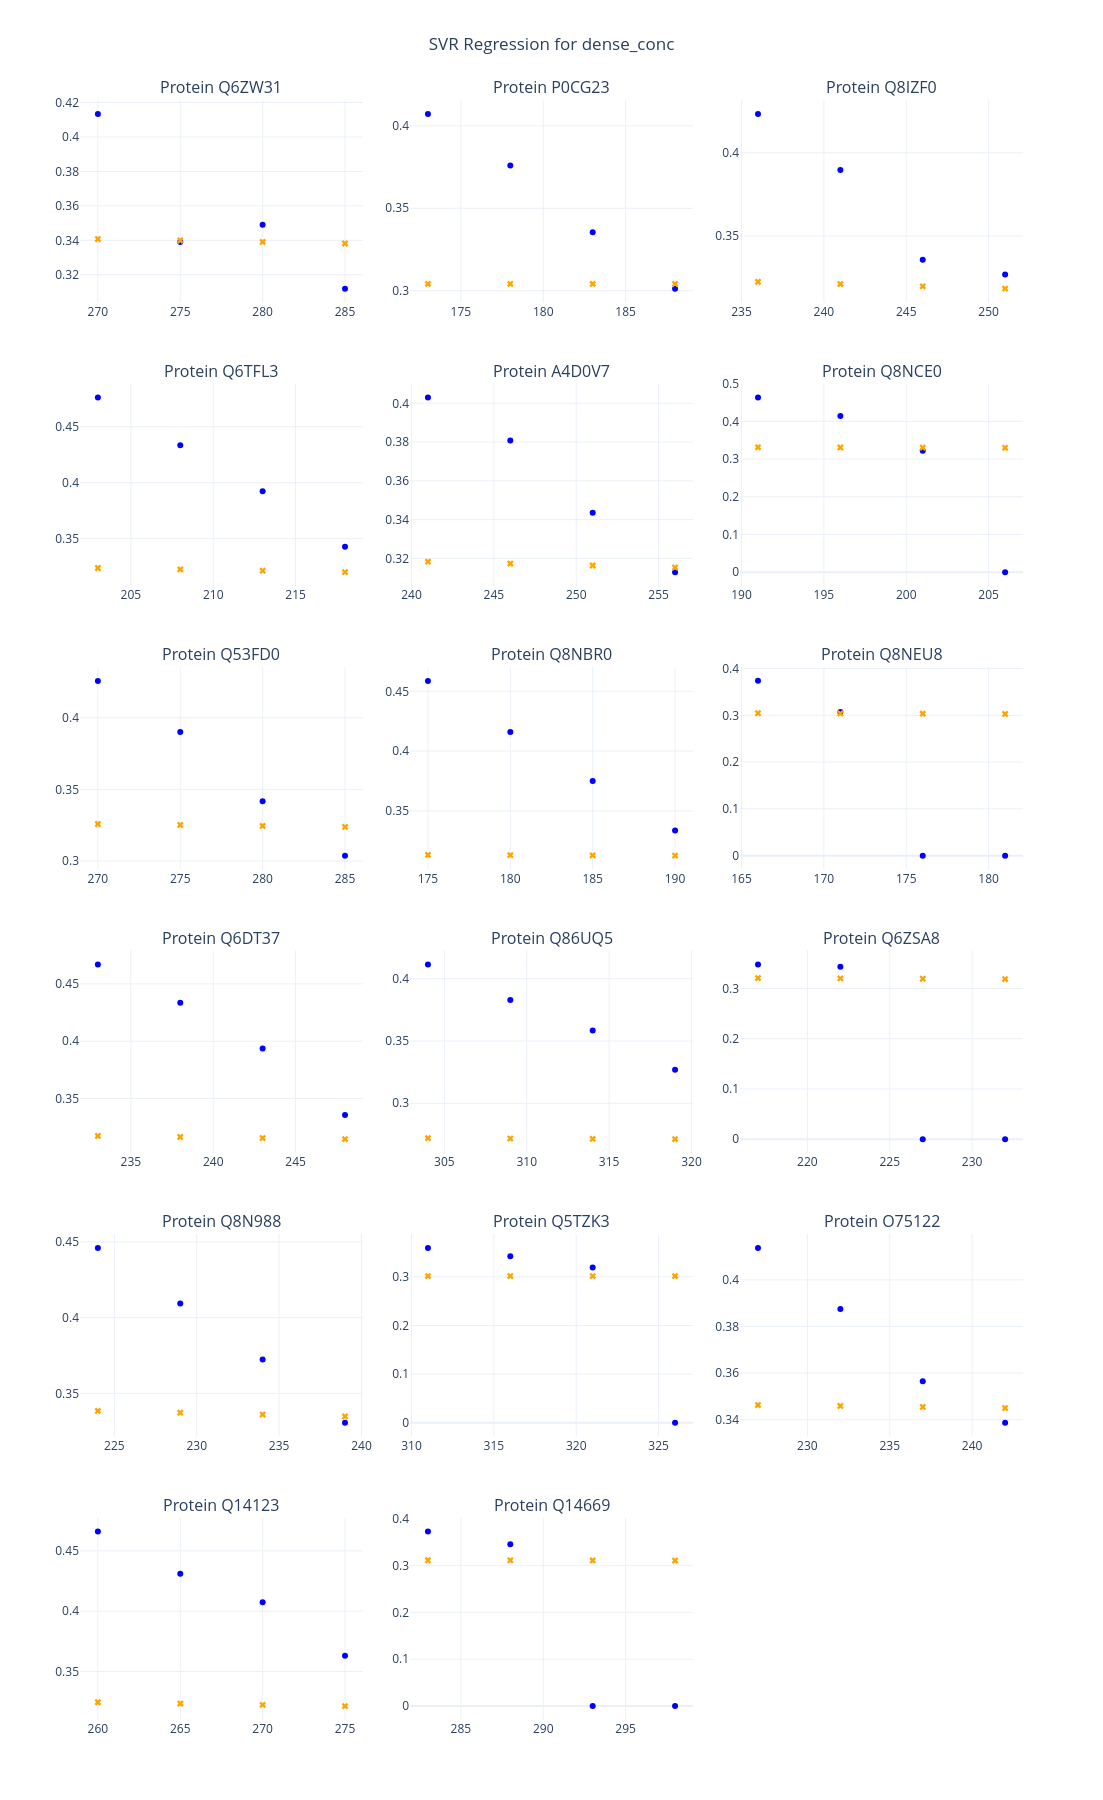

/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [20]:
target = 'dense_conc'
targets_to_remove = ['ct', 'conc_dilute', 'var_dilute', 'var_dense']
dataset = 'new'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'C': Real(1e-6, 1e+3, prior='log-uniform'),  # Regularization parameter, log-uniform distribution
    'kernel': Categorical(['rbf']),
    'gamma': Categorical(['scale']),
    'epsilon': Real(0.001, 0.1, prior='log-uniform'),  # Epsilon in the epsilon-SVR model
    'shrinking': Categorical([True, False]),  # Shrinking heuristic
    'max_iter': Categorical([1_000_000])
}

model = SVR()

_, _ = run_ml_pipeline(df_new_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

Preprocessing input data...
Training on 66 proteins
Testing on 17 proteins
Searching for the best RandomForestRegressor hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast

/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Bayesian optimization completed in 1.19 minutes.
Best parameters found: OrderedDict([('bootstrap', True), ('criterion', 'squared_error'), ('max_depth', 3), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 74)])
Test score: 0.08862875501880874
mean_absolute_error: 0.0918
mean_squared_error: 0.0151
root_mean_squared_error: 0.1229
r2_score: 0.0886
explained_variance_score: 0.1037
Plotting Test predictions...


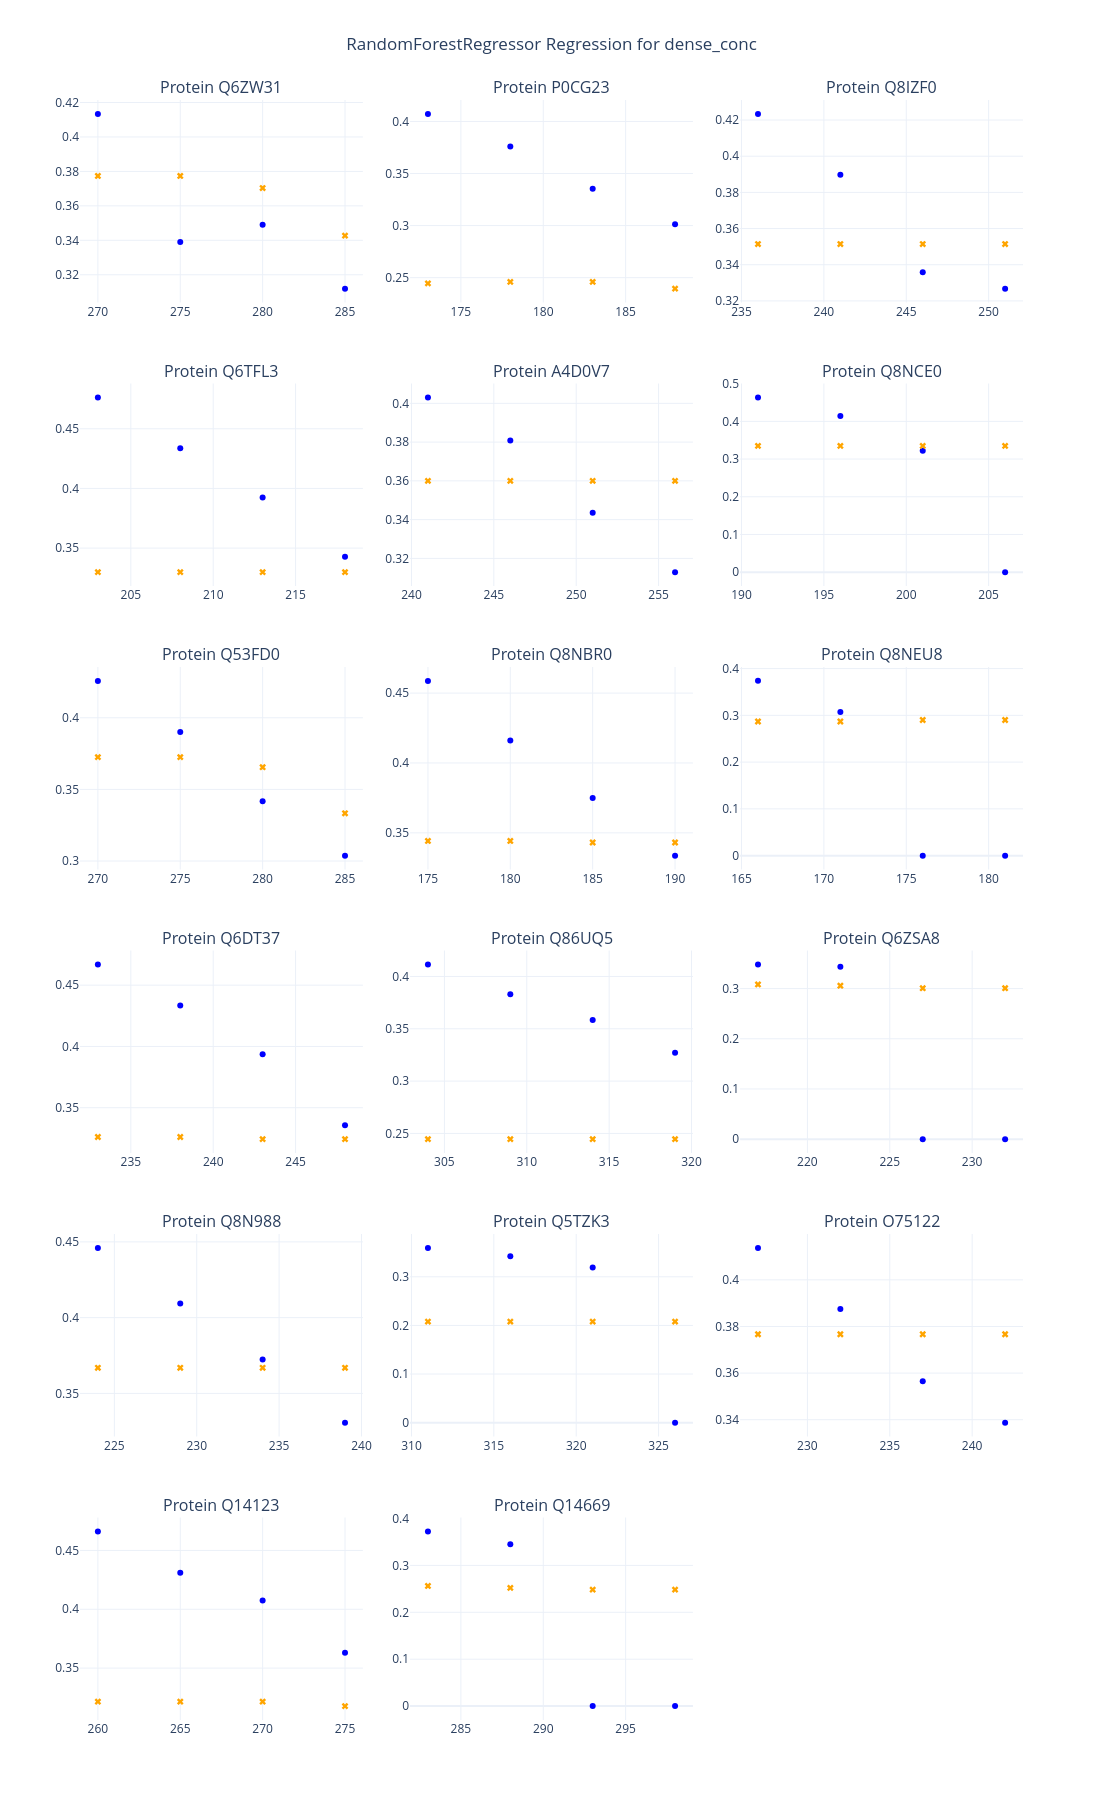

/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

/tmp/ipykernel_17184/1914520831.py:190: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_17184/1914520831.py:191: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_17184/1914520831.py:193: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [21]:
target = 'dense_conc'
targets_to_remove = ['ct', 'conc_dilute', 'var_dilute', 'var_dense']
dataset = 'new'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'n_estimators': Integer(2, 100),
    'max_depth': Integer(3, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['squared_error', 'absolute_error', 'poisson']),
}

model = RandomForestRegressor(random_state=seed)

_, _ = run_ml_pipeline(df_new_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

### 1.2 Train on new proteins - conc_dilute

In [22]:
target = 'conc_dilute'
targets_to_remove = ['ct', 'dense_conc', 'var_dilute', 'var_dense']
dataset = 'new'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'C': Real(1e-6, 1e+3, prior='log-uniform'),  # Regularization parameter, log-uniform distribution
    'kernel': Categorical(['rbf']),
    'gamma': Categorical(['scale']),
    'epsilon': Real(0.001, 0.1, prior='log-uniform'),  # Epsilon in the epsilon-SVR model
    'shrinking': Categorical([True, False]),  # Shrinking heuristic
    'max_iter': Categorical([1_000_000])
}

model = SVR()

_, _ = run_ml_pipeline(df_new_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

Preprocessing input data...
Training on 66 proteins
Testing on 17 proteins
Searching for the best SVR hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 ca

/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [23]:
target = 'conc_dilute'
targets_to_remove = ['ct', 'dense_conc', 'var_dilute', 'var_dense']
dataset = 'new'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'n_estimators': Integer(2, 100),
    'max_depth': Integer(3, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['squared_error', 'absolute_error', 'poisson']),
}

model = RandomForestRegressor(random_state=seed)

_, _ = run_ml_pipeline(df_new_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

Preprocessing input data...
Training on 66 proteins
Testing on 17 proteins
Searching for the best RandomForestRegressor hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 fold

/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning:

The objective has been evaluated at point [np.False_, np.str_('poisson'), np.int64(50), np.str_('log2'), np.int64(10), np.int64(10), np.int64(65)] before, using random point [False, 'squared_error', np.int64(37), 'log2', np.int64(4), np.int64(4), np.int64(99)]



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Bayesian optimization completed in 1.12 minutes.
Best parameters found: OrderedDict([('bootstrap', False), ('criterion', 'squared_error'), ('max_depth', 50), ('max_features', 'log2'), ('min_samples_leaf', 10), ('min_samples_split', 10), ('n_estimators', 67)])
Test score: 0.01300281627052291
mean_absolute_error: 0.0164
mean_squared_error: 0.0005
root_mean_squared_error: 0.0229
r2_score: 0.0130
explained_variance_score: 0.0130
Plotting Test predictions...


/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

### 1.3 Train on new proteins - ct

In [24]:
target = 'ct'
targets_to_remove = ['temp', 'conc_dilute', 'dense_conc', 'var_dilute', 'var_dense']
dataset = 'new'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'C': Real(1e-6, 1e+2, prior='log-uniform'),  # Regularization parameter, log-uniform distribution
    'kernel': Categorical(['rbf']),
    'gamma': Categorical(['scale']),
    'epsilon': Real(0.001, 0.1, prior='log-uniform'),  # Epsilon in the epsilon-SVR model
    'shrinking': Categorical([True, False]),  # Shrinking heuristic
    'max_iter': Categorical([1_000_000])
}

model = SVR()

_, _ = run_ml_pipeline(df_new_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

Preprocessing input data...
Training on 66 proteins
Testing on 17 proteins
Searching for the best SVR hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 ca

/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [25]:
target = 'ct'
targets_to_remove = ['temp', 'conc_dilute', 'dense_conc', 'var_dilute', 'var_dense']
dataset = 'new'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'n_estimators': Integer(2, 100),
    'max_depth': Integer(3, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['squared_error', 'absolute_error', 'poisson']),
}

model = RandomForestRegressor(random_state=seed)


_, _ = run_ml_pipeline(df_new_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

Preprocessing input data...
Training on 66 proteins
Testing on 17 proteins
Searching for the best RandomForestRegressor hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

### 2.1 Train on combined data - dense_conc

In [26]:
df_combined_proteins = pd.concat([df_old_proteins, df_new_proteins], axis=0)

In [27]:
target = 'dense_conc'
targets_to_remove = ['ct', 'conc_dilute', 'var_dilute', 'var_dense']
dataset = 'combined'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'C': Real(1e-6, 1e+3, prior='log-uniform'),  # Regularization parameter, log-uniform distribution
    'kernel': Categorical(['rbf']),
    'gamma': Categorical(['scale']),
    'epsilon': Real(0.001, 0.1, prior='log-uniform'),  # Epsilon in the epsilon-SVR model
    'shrinking': Categorical([True, False]),  # Shrinking heuristic
    'max_iter': Categorical([1_000_000])
}

model = SVR()

_, _ = run_ml_pipeline(df_combined_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

Preprocessing input data...
Training on 88 proteins
Testing on 23 proteins
Searching for the best SVR hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 ca

/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

Preprocessing input data...
Training on 88 proteins
Testing on 23 proteins
Searching for the best RandomForestRegressor hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 fold

/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

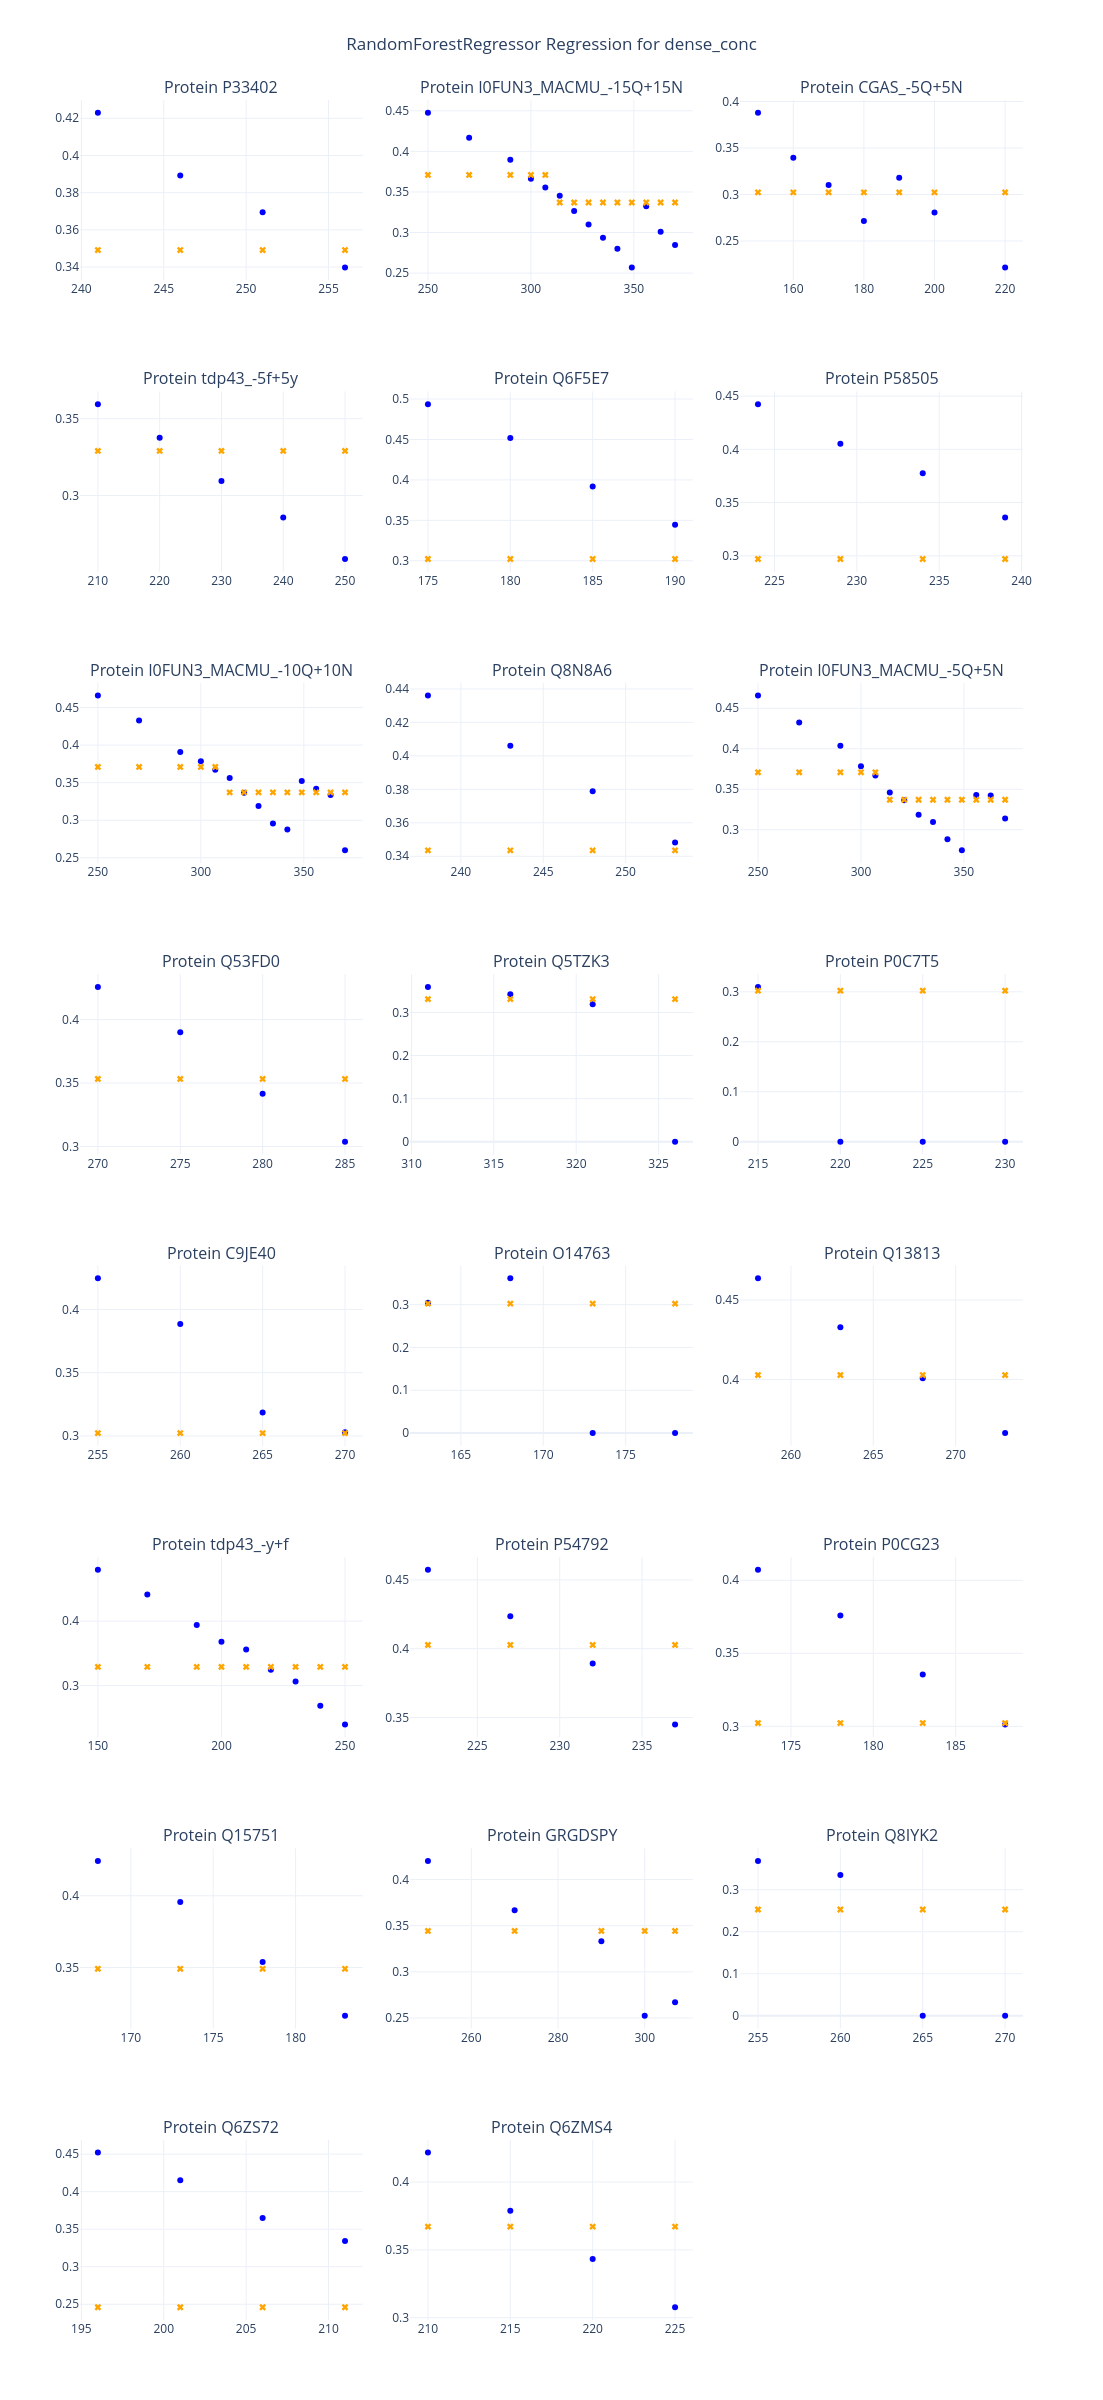

/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [28]:
target = 'dense_conc'
targets_to_remove = ['ct', 'conc_dilute', 'var_dilute', 'var_dense']
dataset = 'combined'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'n_estimators': Integer(2, 100),
    'max_depth': Integer(3, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['squared_error', 'absolute_error', 'poisson']),
}

model = RandomForestRegressor(random_state=seed)

_, _ = run_ml_pipeline(df_combined_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

### 2.2 Train on combined data - conc_dilute

Preprocessing input data...
Training on 88 proteins
Testing on 23 proteins
Searching for the best SVR hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 ca

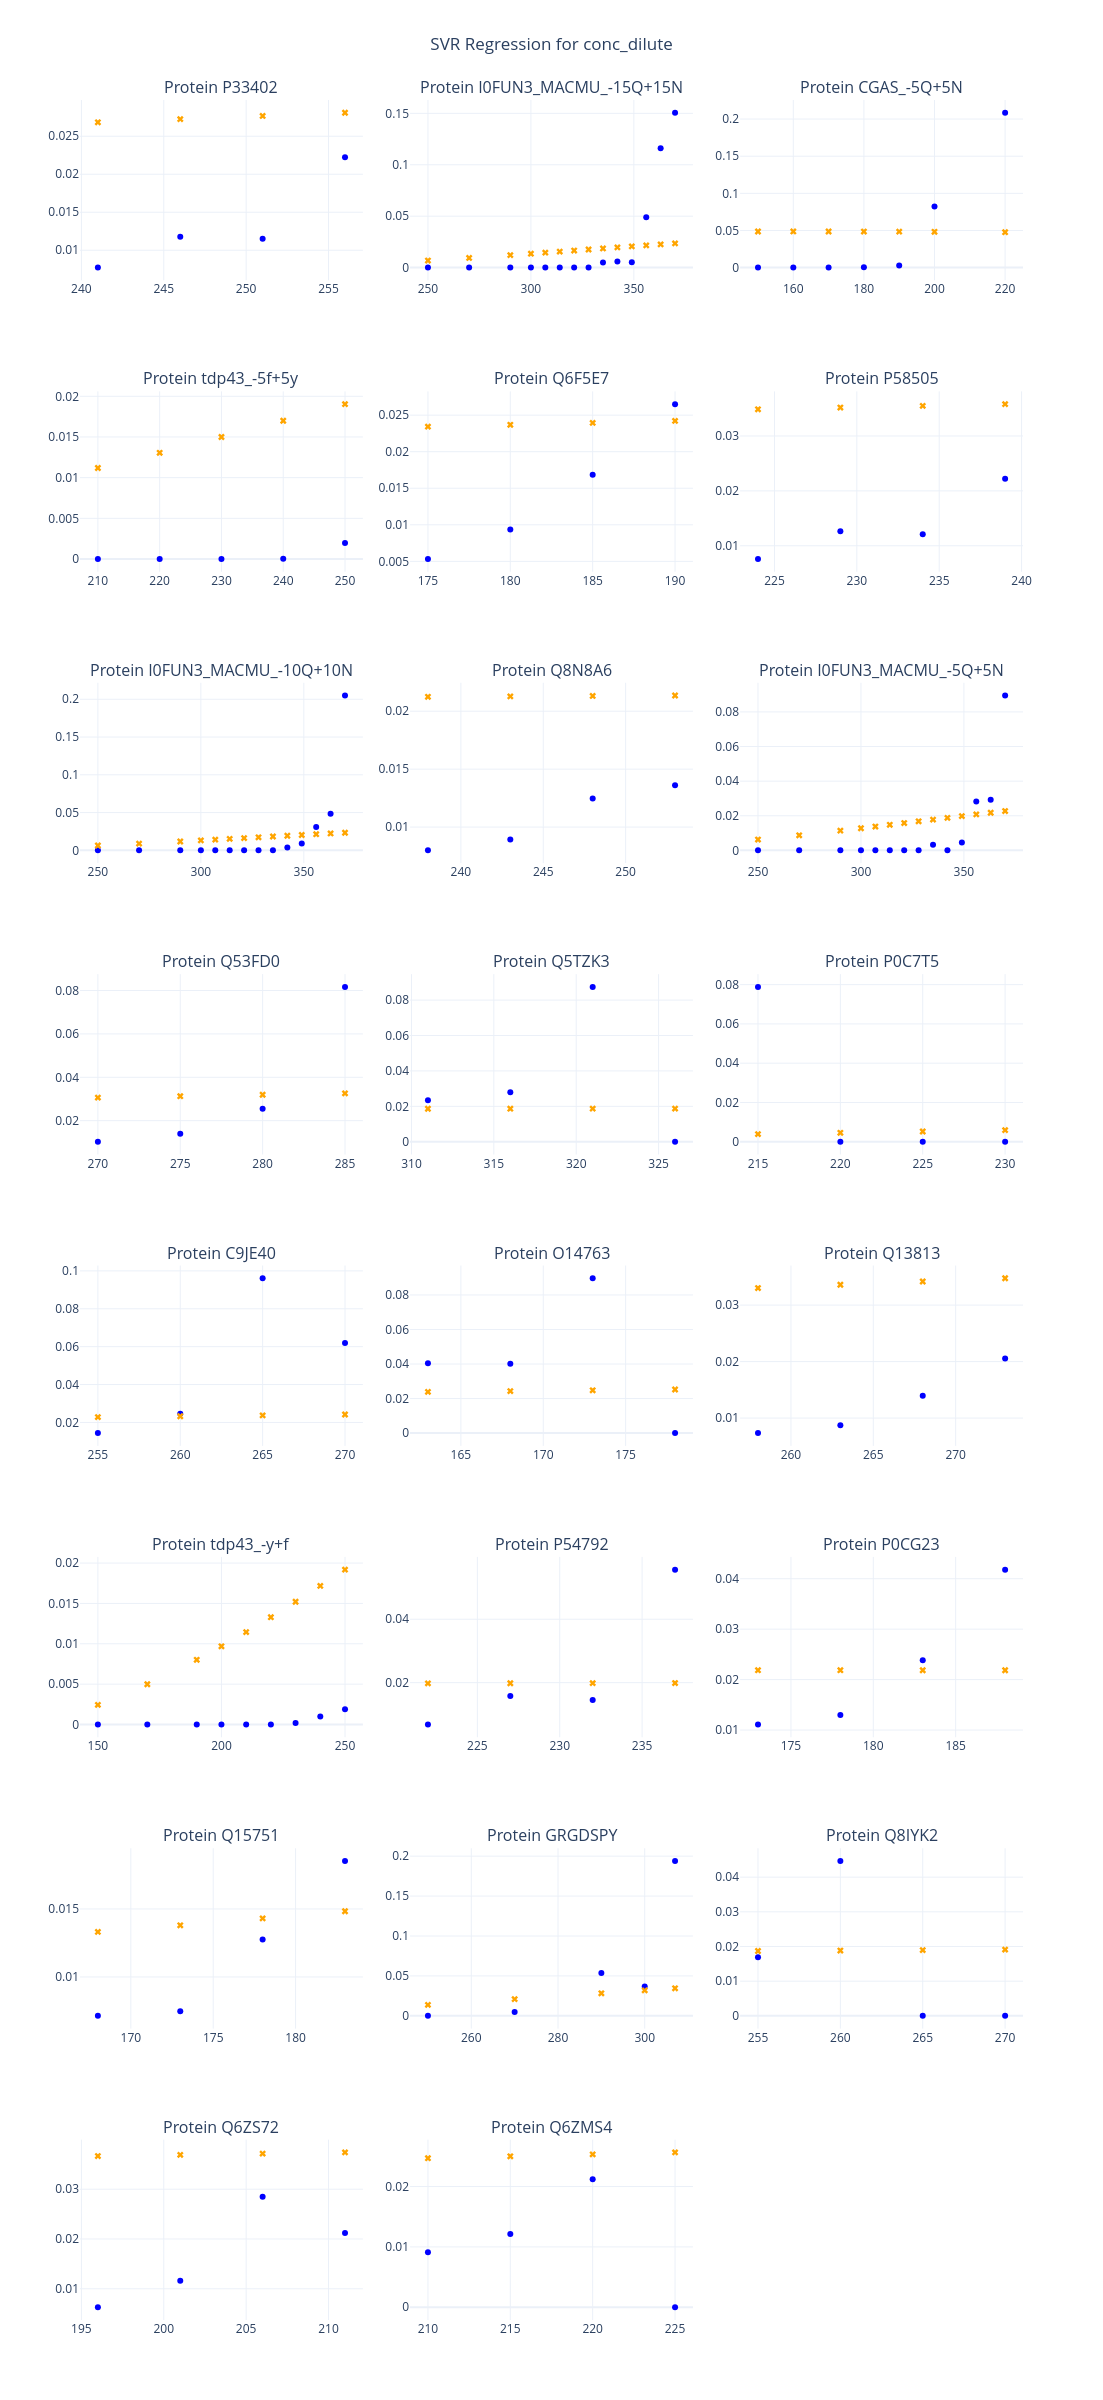

/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [29]:
target = 'conc_dilute'
targets_to_remove = ['ct', 'dense_conc', 'var_dilute', 'var_dense']
dataset = 'combined'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'C': Real(1e-6, 1e+3, prior='log-uniform'),  # Regularization parameter, log-uniform distribution
    'kernel': Categorical(['rbf']),
    'gamma': Categorical(['scale']),
    'epsilon': Real(0.001, 0.1, prior='log-uniform'),  # Epsilon in the epsilon-SVR model
    'shrinking': Categorical([True, False]),  # Shrinking heuristic
    'max_iter': Categorical([1_000_000])
}

model = SVR()

_, _ = run_ml_pipeline(df_combined_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

Preprocessing input data...
Training on 88 proteins
Testing on 23 proteins
Searching for the best RandomForestRegressor hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

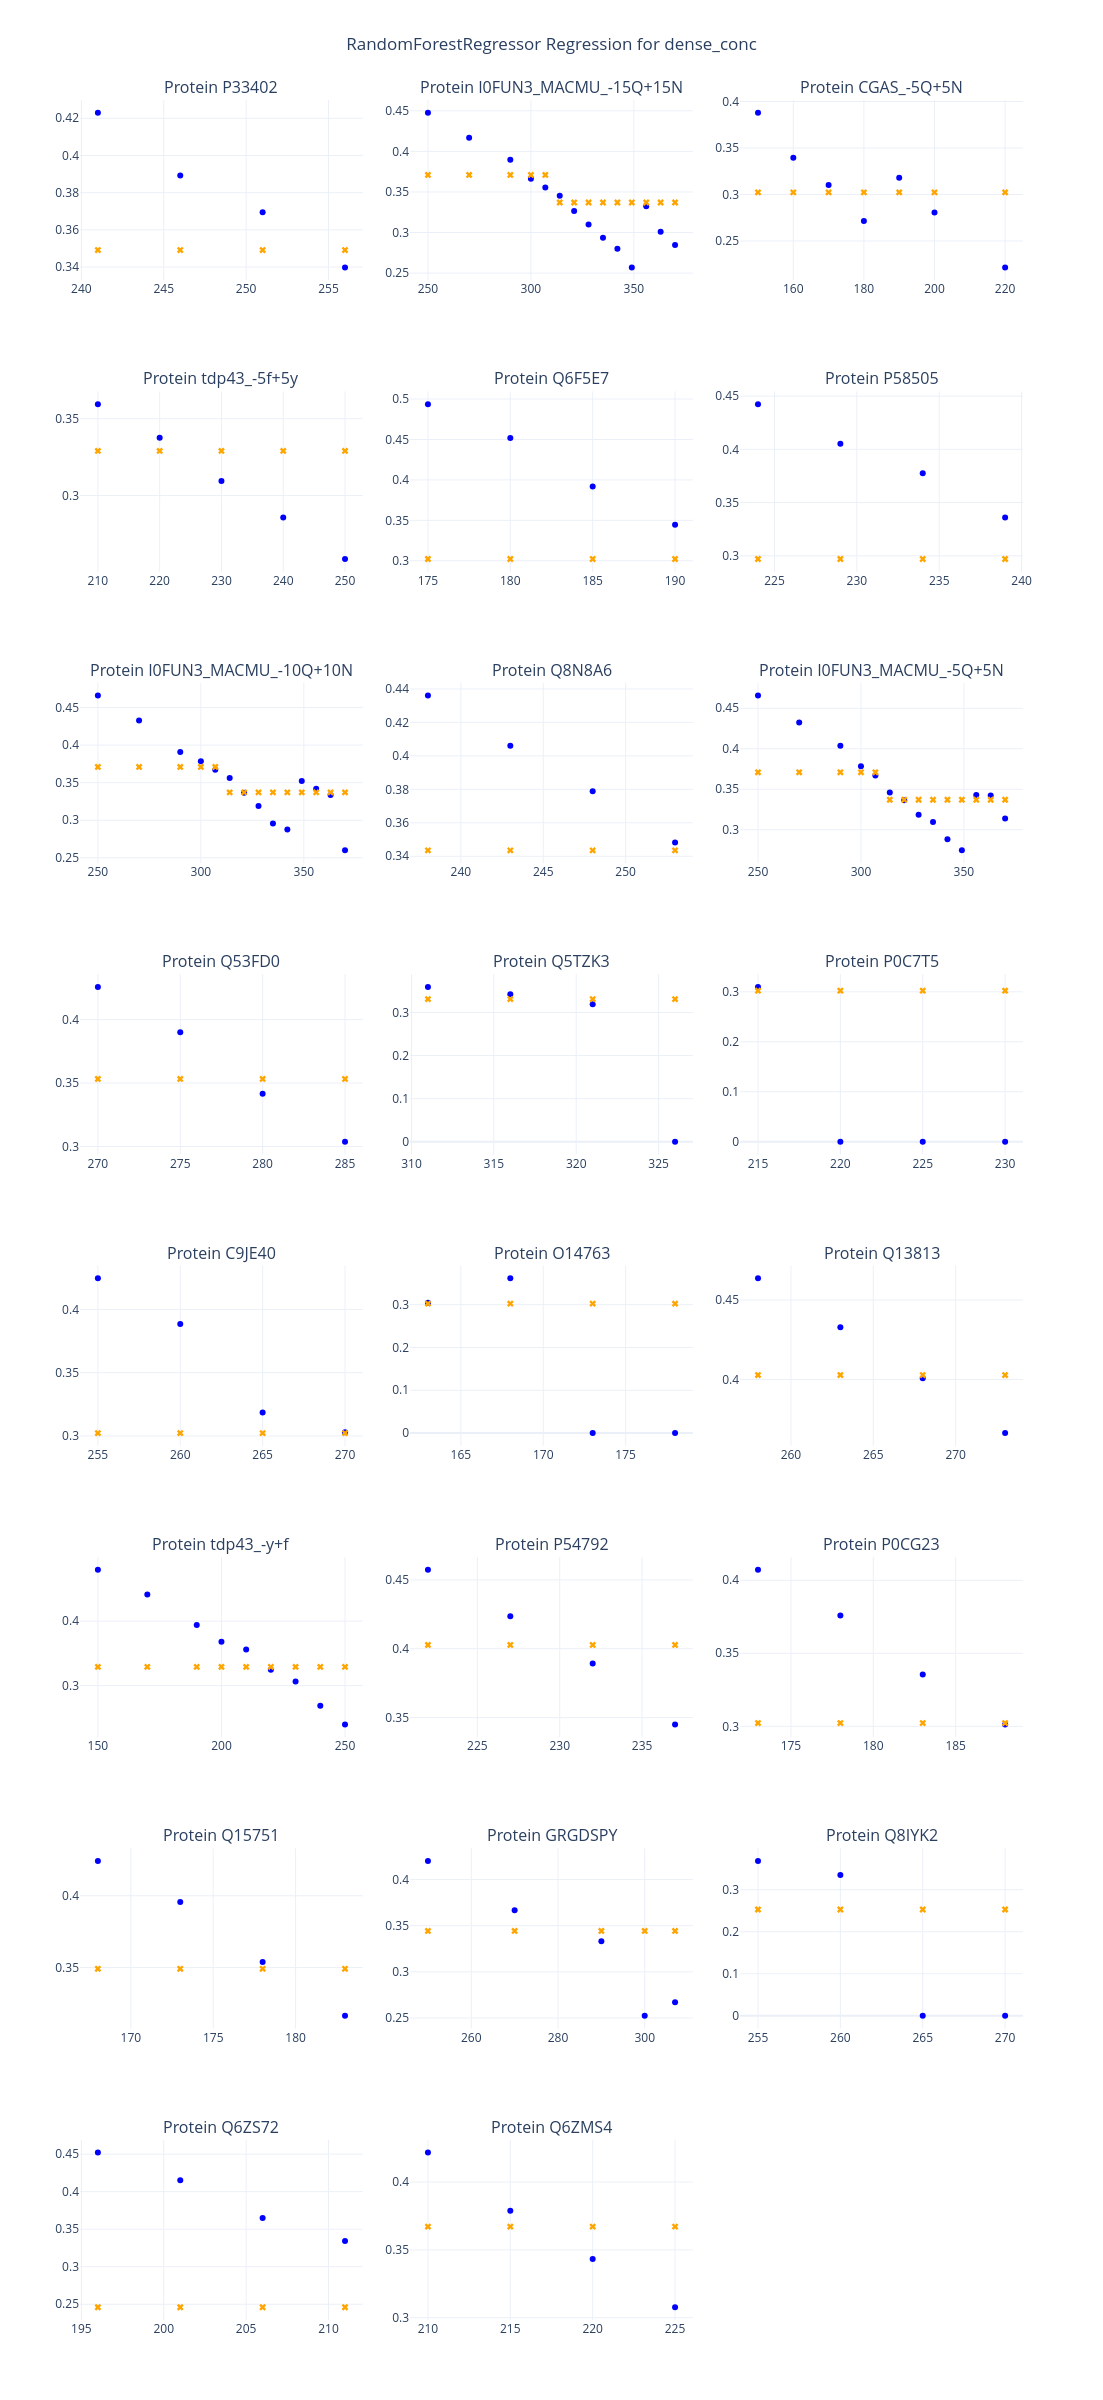

/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [30]:
target = 'dense_conc'
targets_to_remove = ['ct', 'conc_dilute', 'var_dilute', 'var_dense']
dataset = 'combined'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'n_estimators': Integer(2, 100),
    'max_depth': Integer(3, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['squared_error', 'absolute_error', 'poisson']),
}

model = RandomForestRegressor(random_state=seed)

_, _ = run_ml_pipeline(df_combined_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

### 2.3 Train on combined data - ct

Preprocessing input data...
Training on 88 proteins
Testing on 23 proteins
Searching for the best SVR hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

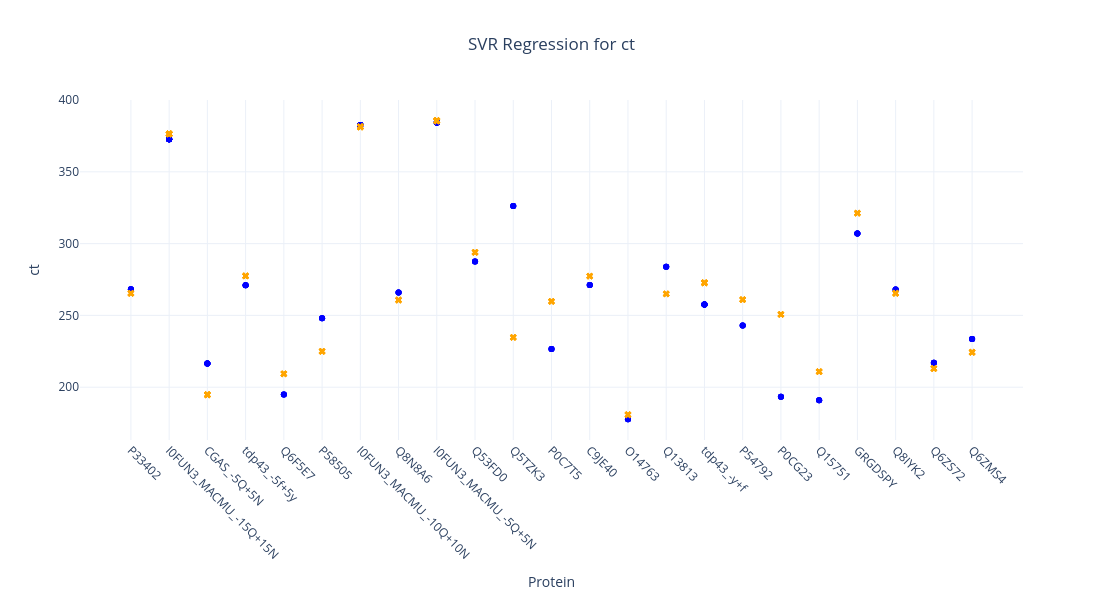

/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [31]:
target = 'ct'
targets_to_remove = ['temp', 'conc_dilute', 'dense_conc', 'var_dilute', 'var_dense']
dataset = 'combined'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'C': Real(1e-6, 1e+3, prior='log-uniform'),  # Regularization parameter, log-uniform distribution
    'kernel': Categorical(['rbf']),
    'gamma': Categorical(['scale']),
    'epsilon': Real(0.001, 0.1, prior='log-uniform'),  # Epsilon in the epsilon-SVR model
    'shrinking': Categorical([True, False]),  # Shrinking heuristic
    'max_iter': Categorical([1_000_000])
}

model = SVR()

_, _ = run_ml_pipeline(df_combined_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

Preprocessing input data...
Training on 88 proteins
Testing on 23 proteins
Searching for the best RandomForestRegressor hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/vik/toptal/harryschemlab/HarryML/venv/lib/python3.10/site-packages/numpy/ma/core.py:2892: RuntimeWarning:

invalid value encountered in cast



Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

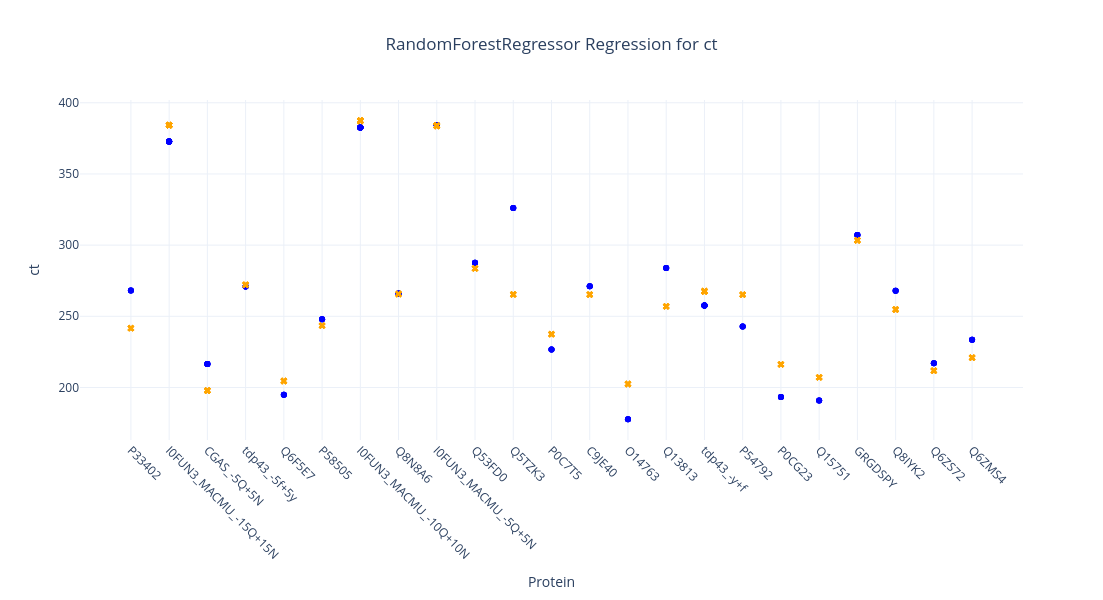

/tmp/ipykernel_65780/3920784150.py:244: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:245: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_65780/3920784150.py:247: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [32]:
target = 'ct'
targets_to_remove = ['temp', 'conc_dilute', 'dense_conc', 'var_dilute', 'var_dense']
dataset = 'combined'

seed = 2025
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'n_estimators': Integer(2, 100),
    'max_depth': Integer(3, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Categorical(['sqrt', 'log2']),
    'bootstrap': Categorical([True, False]),
    'criterion': Categorical(['squared_error', 'absolute_error', 'poisson']),
}

model = RandomForestRegressor(random_state=seed)

_, _ = run_ml_pipeline(df_combined_proteins, target, targets_to_remove, model, 
                search_space, n_iter, cv_folds, num_cores, seed, dataset, True)

### 3.1 Train on old data (more temperature measurements / protein), test on new data (4 temperature measurements / protein)

In [33]:
target = 'ct'
targets_to_remove = ['temp', 'dense_conc', 'conc_dilute', 'var_dilute', 'var_dense']

seed = 1
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'C': Real(1e-6, 1e+3, prior='log-uniform'),  # Regularization parameter, log-uniform distribution
    'kernel': Categorical(['rbf']),
    'gamma': Categorical(['scale']),
    'epsilon': Real(0.001, 0.1, prior='log-uniform'),  # Epsilon in the epsilon-SVR model
    'shrinking': Categorical([True, False]),  # Shrinking heuristic
    'max_iter': Categorical([1_000_000])
}

model = SVR()

In [34]:
df_proteins = df_old_proteins.copy()

col_protein = 'protein_name'

main_metric = 'r2'
scoring_metrics = [
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_root_mean_squared_error',
    'r2',
    'explained_variance'
]
metrics = [
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    explained_variance_score
]
scaler_features = StandardScaler()

print("Preprocessing input data...")

features = [col for col in df_proteins.columns if col != target and col != col_protein and col not in targets_to_remove]

proteins = df_proteins[col_protein].unique()

train_proteins, test_proteins = train_test_split(proteins, train_size=0.8, random_state=seed, shuffle=True)

print(f"Training on {len(train_proteins)} proteins")
print(f"Testing on {len(test_proteins)} proteins")

df_src = df_proteins.copy()
df_src.drop(targets_to_remove, axis=1, inplace=True)

df_train = df_src.loc[df_proteins[col_protein].isin(train_proteins)]
df_test = df_src.loc[df_proteins[col_protein].isin(test_proteins)]

x_train, y_train = df_train.loc[:, features], df_train.loc[:, [target]].values.ravel()
x_test, y_test = df_test.loc[:, features], df_test.loc[:, [target]].values.ravel()

x_train = scaler_features.fit_transform(x_train)
x_test = scaler_features.transform(x_test)

print(f"Searching for the best {type(model).__name__} hyperparameters with Bayesian Search...")

bayes_search = BayesSearchCV(
    model,
    search_space,
    scoring=scoring_metrics,
    refit=main_metric,
    n_iter=n_iter,
    cv=cv_folds,
    n_jobs=num_cores,
    verbose=1,
    random_state=seed
)

start_time = time.time()

bayes_search.fit(x_train, y_train)

end_time = time.time()
elapsed_time = (end_time - start_time) / 60

print(f"Bayesian optimization completed in {elapsed_time:.2f} minutes.")
print("Best parameters found:", bayes_search.best_params_)
print("Test score:", bayes_search.score(x_test, y_test))

model = bayes_search.best_estimator_
model.fit(x_train, y_train)

test_preds = model.predict(x_test)

for metr in metrics:
    print(f'{metr.__name__}: {metr(y_test, test_preds):.4f}')

Preprocessing input data...
Training on 22 proteins
Testing on 6 proteins
Searching for the best SVR hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 can

In [35]:
x_test, y_test = df_new_proteins.loc[:, features], df_new_proteins.loc[:, [target]].values.ravel()

x_test = scaler_features.transform(x_test)

test_preds = model.predict(x_test)

for metr in metrics:
    print(f'{metr.__name__}: {metr(y_test, test_preds):.4f}')

mean_absolute_error: 42.2434
mean_squared_error: 2751.4773
root_mean_squared_error: 52.4545
r2_score: -0.9348
explained_variance_score: -0.1751


### 3.2 Train set = proteins with 4 samples, Test set = proteins with > 4 samples

In [36]:
# Ratio of proteins with given number of temperature samples

df_sample_stats = df_combined_proteins.groupby('protein_name')['temp'].count().value_counts().reset_index()
df_sample_stats['ratio'] = df_sample_stats['count'] / df_combined_proteins.protein_name.nunique()
df_sample_stats.rename(columns={'temp': 'samples'}, inplace=True)

df_sample_stats

samples  count     ratio
0        4     83  0.747748
1       14      7  0.063063
2        6      5  0.045045
3        5      5  0.045045
4        8      4  0.036036
5        9      2  0.018018
6        7      2  0.018018
7       13      2  0.018018
8       11      1  0.009009

In [37]:
target = 'ct'
targets_to_remove = ['temp', 'dense_conc', 'conc_dilute', 'var_dilute', 'var_dense']

seed = 1
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'C': Real(1e-6, 1e+3, prior='log-uniform'),  # Regularization parameter, log-uniform distribution
    'kernel': Categorical(['rbf']),
    'gamma': Categorical(['scale']),
    'epsilon': Real(0.001, 0.1, prior='log-uniform'),  # Epsilon in the epsilon-SVR model
    'shrinking': Categorical([True, False]),  # Shrinking heuristic
    'max_iter': Categorical([1_000_000])
}

model = SVR()

In [38]:
df_proteins = df_combined_proteins.copy()
df_sample_counts = df_combined_proteins.groupby('protein_name')['temp'].count()

col_protein = 'protein_name'

main_metric = 'r2'
scoring_metrics = [
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_root_mean_squared_error',
    'r2',
    'explained_variance'
]
metrics = [
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    explained_variance_score
]
scaler_features = StandardScaler()

print("Preprocessing input data...")

features = [col for col in df_proteins.columns if col != target and col != col_protein and col not in targets_to_remove]

train_proteins = df_sample_counts[df_sample_counts == 4].index.tolist()
test_proteins = df_sample_counts[df_sample_counts > 4].index.tolist()

print(f"Training on {len(train_proteins)} proteins")
print(f"Testing on {len(test_proteins)} proteins")

df_src = df_proteins.copy()
df_src.drop(targets_to_remove, axis=1, inplace=True)

df_train = df_src.loc[df_proteins[col_protein].isin(train_proteins)]
df_test = df_src.loc[df_proteins[col_protein].isin(test_proteins)]

x_train, y_train = df_train.loc[:, features], df_train.loc[:, [target]].values.ravel()
x_test, y_test = df_test.loc[:, features], df_test.loc[:, [target]].values.ravel()

x_train = scaler_features.fit_transform(x_train)
x_test = scaler_features.transform(x_test)

print(f"Searching for the best {type(model).__name__} hyperparameters with Bayesian Search...")

bayes_search = BayesSearchCV(
    model,
    search_space,
    scoring=scoring_metrics,
    refit=main_metric,
    n_iter=n_iter,
    cv=cv_folds,
    n_jobs=num_cores,
    verbose=1,
    random_state=seed
)

start_time = time.time()

bayes_search.fit(x_train, y_train)

end_time = time.time()
elapsed_time = (end_time - start_time) / 60

print(f"Bayesian optimization completed in {elapsed_time:.2f} minutes.")
print("Best parameters found:", bayes_search.best_params_)
print("Test score:", bayes_search.score(x_test, y_test))

model = bayes_search.best_estimator_
model.fit(x_train, y_train)

test_preds = model.predict(x_test)

for metr in metrics:
    print(f'{metr.__name__}: {metr(y_test, test_preds):.4f}')

Preprocessing input data...
Training on 83 proteins
Testing on 28 proteins
Searching for the best SVR hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 ca

### 3.3 Stratified split based on samples > 4 condition

### Target - dense_conc

In [39]:
target = 'dense_conc'
targets_to_remove = ['ct', 'conc_dilute', 'var_dilute', 'var_dense']

seed = 1
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'C': Real(1e-6, 1e+3, prior='log-uniform'),  # Regularization parameter, log-uniform distribution
    'kernel': Categorical(['rbf']),
    'gamma': Categorical(['scale']),
    'epsilon': Real(0.001, 0.1, prior='log-uniform'),  # Epsilon in the epsilon-SVR model
    'shrinking': Categorical([True, False]),  # Shrinking heuristic
    'max_iter': Categorical([1_000_000])
}

model = SVR()

In [40]:
df_proteins = df_combined_proteins.copy()
df_sample_counts = df_proteins.groupby('protein_name')['temp'].count()
df_condition = (df_sample_counts > 4).reset_index(name='condition')

train_proteins, test_proteins = train_test_split(
    df_condition.protein_name, 
    stratify=df_condition.condition, 
    train_size=0.8, random_state=seed, shuffle=True
)

col_protein = 'protein_name'

main_metric = 'r2'
scoring_metrics = [
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_root_mean_squared_error',
    'r2',
    'explained_variance'
]
metrics = [
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    explained_variance_score
]
scaler_features = StandardScaler()

print("Preprocessing input data...")

features = [col for col in df_proteins.columns if col != target and col != col_protein and col not in targets_to_remove]

print(f"Training on {len(train_proteins)} proteins")
print(f"Testing on {len(test_proteins)} proteins")

df_src = df_proteins.copy()
df_src.drop(targets_to_remove, axis=1, inplace=True)

df_train = df_src.loc[df_proteins[col_protein].isin(train_proteins)]
df_test = df_src.loc[df_proteins[col_protein].isin(test_proteins)]

x_train, y_train = df_train.loc[:, features], df_train.loc[:, [target]].values.ravel()
x_test, y_test = df_test.loc[:, features], df_test.loc[:, [target]].values.ravel()

x_train = scaler_features.fit_transform(x_train)
x_test = scaler_features.transform(x_test)

print(f"Searching for the best {type(model).__name__} hyperparameters with Bayesian Search...")

bayes_search = BayesSearchCV(
    model,
    search_space,
    scoring=scoring_metrics,
    refit=main_metric,
    n_iter=n_iter,
    cv=cv_folds,
    n_jobs=num_cores,
    verbose=1,
    random_state=seed
)

start_time = time.time()

bayes_search.fit(x_train, y_train)

end_time = time.time()
elapsed_time = (end_time - start_time) / 60

print(f"Bayesian optimization completed in {elapsed_time:.2f} minutes.")
print("Best parameters found:", bayes_search.best_params_)
print("Test score:", bayes_search.score(x_test, y_test))

model = bayes_search.best_estimator_
model.fit(x_train, y_train)

test_preds = model.predict(x_test)

for metr in metrics:
    print(f'{metr.__name__}: {metr(y_test, test_preds):.4f}')

Preprocessing input data...
Training on 88 proteins
Testing on 23 proteins
Searching for the best SVR hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 ca

### Target - conc_dilute

In [41]:
target = 'conc_dilute'
targets_to_remove = ['ct', 'dense_conc', 'var_dilute', 'var_dense']

seed = 1
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'C': Real(1e-6, 1e+3, prior='log-uniform'),  # Regularization parameter, log-uniform distribution
    'kernel': Categorical(['rbf']),
    'gamma': Categorical(['scale']),
    'epsilon': Real(0.001, 0.1, prior='log-uniform'),  # Epsilon in the epsilon-SVR model
    'shrinking': Categorical([True, False]),  # Shrinking heuristic
    'max_iter': Categorical([1_000_000])
}

model = SVR()

In [42]:
df_proteins = df_combined_proteins.copy()
df_sample_counts = df_proteins.groupby('protein_name')['temp'].count()
df_condition = (df_sample_counts > 4).reset_index(name='condition')

train_proteins, test_proteins = train_test_split(
    df_condition.protein_name, 
    stratify=df_condition.condition, 
    train_size=0.8, random_state=seed, shuffle=True
)

col_protein = 'protein_name'

main_metric = 'r2'
scoring_metrics = [
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_root_mean_squared_error',
    'r2',
    'explained_variance'
]
metrics = [
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    explained_variance_score
]
scaler_features = StandardScaler()

print("Preprocessing input data...")

features = [col for col in df_proteins.columns if col != target and col != col_protein and col not in targets_to_remove]

print(f"Training on {len(train_proteins)} proteins")
print(f"Testing on {len(test_proteins)} proteins")

df_src = df_proteins.copy()
df_src.drop(targets_to_remove, axis=1, inplace=True)

df_train = df_src.loc[df_proteins[col_protein].isin(train_proteins)]
df_test = df_src.loc[df_proteins[col_protein].isin(test_proteins)]

x_train, y_train = df_train.loc[:, features], df_train.loc[:, [target]].values.ravel()
x_test, y_test = df_test.loc[:, features], df_test.loc[:, [target]].values.ravel()

x_train = scaler_features.fit_transform(x_train)
x_test = scaler_features.transform(x_test)

print(f"Searching for the best {type(model).__name__} hyperparameters with Bayesian Search...")

bayes_search = BayesSearchCV(
    model,
    search_space,
    scoring=scoring_metrics,
    refit=main_metric,
    n_iter=n_iter,
    cv=cv_folds,
    n_jobs=num_cores,
    verbose=1,
    random_state=seed
)

start_time = time.time()

bayes_search.fit(x_train, y_train)

end_time = time.time()
elapsed_time = (end_time - start_time) / 60

print(f"Bayesian optimization completed in {elapsed_time:.2f} minutes.")
print("Best parameters found:", bayes_search.best_params_)
print("Test score:", bayes_search.score(x_test, y_test))

model = bayes_search.best_estimator_
model.fit(x_train, y_train)

test_preds = model.predict(x_test)

for metr in metrics:
    print(f'{metr.__name__}: {metr(y_test, test_preds):.4f}')

Preprocessing input data...
Training on 88 proteins
Testing on 23 proteins
Searching for the best SVR hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 ca

### Target - ct

In [43]:
target = 'ct'
targets_to_remove = ['temp', 'dense_conc', 'conc_dilute', 'var_dilute', 'var_dense']

seed = 1
n_iter = 50
cv_folds = 3
num_cores = 12

search_space = {
    'C': Real(1e-6, 1e+3, prior='log-uniform'),  # Regularization parameter, log-uniform distribution
    'kernel': Categorical(['rbf']),
    'gamma': Categorical(['scale']),
    'epsilon': Real(0.001, 0.1, prior='log-uniform'),  # Epsilon in the epsilon-SVR model
    'shrinking': Categorical([True, False]),  # Shrinking heuristic
    'max_iter': Categorical([1_000_000])
}

model = SVR()

In [44]:
df_proteins = df_combined_proteins.copy()
df_sample_counts = df_proteins.groupby('protein_name')['temp'].count()
df_condition = (df_sample_counts > 4).reset_index(name='condition')

train_proteins, test_proteins = train_test_split(
    df_condition.protein_name, 
    stratify=df_condition.condition, 
    train_size=0.8, random_state=seed, shuffle=True
)

col_protein = 'protein_name'

main_metric = 'r2'
scoring_metrics = [
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_root_mean_squared_error',
    'r2',
    'explained_variance'
]
metrics = [
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    explained_variance_score
]
scaler_features = StandardScaler()

print("Preprocessing input data...")

features = [col for col in df_proteins.columns if col != target and col != col_protein and col not in targets_to_remove]

print(f"Training on {len(train_proteins)} proteins")
print(f"Testing on {len(test_proteins)} proteins")

df_src = df_proteins.copy()
df_src.drop(targets_to_remove, axis=1, inplace=True)

df_train = df_src.loc[df_proteins[col_protein].isin(train_proteins)]
df_test = df_src.loc[df_proteins[col_protein].isin(test_proteins)]

x_train, y_train = df_train.loc[:, features], df_train.loc[:, [target]].values.ravel()
x_test, y_test = df_test.loc[:, features], df_test.loc[:, [target]].values.ravel()

x_train = scaler_features.fit_transform(x_train)
x_test = scaler_features.transform(x_test)

print(f"Searching for the best {type(model).__name__} hyperparameters with Bayesian Search...")

bayes_search = BayesSearchCV(
    model,
    search_space,
    scoring=scoring_metrics,
    refit=main_metric,
    n_iter=n_iter,
    cv=cv_folds,
    n_jobs=num_cores,
    verbose=1,
    random_state=seed
)

start_time = time.time()

bayes_search.fit(x_train, y_train)

end_time = time.time()
elapsed_time = (end_time - start_time) / 60

print(f"Bayesian optimization completed in {elapsed_time:.2f} minutes.")
print("Best parameters found:", bayes_search.best_params_)
print("Test score:", bayes_search.score(x_test, y_test))

model = bayes_search.best_estimator_
model.fit(x_train, y_train)

test_preds = model.predict(x_test)

for metr in metrics:
    print(f'{metr.__name__}: {metr(y_test, test_preds):.4f}')

Preprocessing input data...
Training on 88 proteins
Testing on 23 proteins
Searching for the best SVR hyperparameters with Bayesian Search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 ca